# Analiza LSTM dla cen zbóż (kukurydza, soja, pszenica)

Ten notebook zawiera przykład analizy szeregów czasowych dla cen zbóż z wykorzystaniem sieci LSTM (Long Short-Term Memory). 

## Cele analizy:
- Przewidywanie przyszłych cen kukurydzy, soi i pszenicy
- Porównanie wydajności modeli dla różnych zbóż
- Analiza wzorców sezonowych i trendów w cenach

In [ ]:
# Instalacja niezbędnych pakietów
import subprocess
import sys

packages = [
    'tensorflow',
    'numpy', 
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'yfinance',  # do pobierania danych giełdowych
    'plotly',
    'nbformat>=4.2.0'  # dodane dla plotly
]

for package in packages:
    try:
        pkg_name = package.split('>=')[0].replace('-', '_')
        __import__(pkg_name)
        print(f"{package} już zainstalowany")
    except ImportError:
        print(f"Instalowanie {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} zainstalowany")

✓ tensorflow już zainstalowany
✓ numpy już zainstalowany
✓ pandas już zainstalowany
✓ matplotlib już zainstalowany
✓ seaborn już zainstalowany
Instalowanie scikit-learn...
✓ scikit-learn zainstalowany
✓ yfinance już zainstalowany
✓ plotly już zainstalowany
Instalowanie nbformat>=4.2.0...
✓ scikit-learn zainstalowany
✓ yfinance już zainstalowany
✓ plotly już zainstalowany
Instalowanie nbformat>=4.2.0...
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.37.0-p

In [2]:
# Importy bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Ustawienia wizualizacji
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Wszystkie biblioteki załadowane pomyślnie!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

2025-12-08 09:31:04.237837: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 09:31:04.282329: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 09:31:05.402453: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 09:31:05.402453: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Wszystkie biblioteki załadowane pomyślnie!
TensorFlow version: 2.20.0
Pandas version: 2.3.3
NumPy version: 2.3.5


In [ ]:
# Pobieranie danych dla zbóż z Yahoo Finance
# Symbole dla kontraktów terminowych na zboża:
# CORN: Kukurydza
# WEAT: Pszenica  
# SOYB: Soja

symbols = {
    'CORN': 'Kukurydza',
    'WEAT': 'Pszenica', 
    'SOYB': 'Soja'
}

# Pobieranie danych z ostatnich 5 lat
start_date = '2019-01-01'
end_date = '2024-12-01'

grain_data = {}

for symbol, name in symbols.items():
    try:
        ticker = yf.Ticker(symbol)
        data = ticker.history(start=start_date, end=end_date)
        
        if not data.empty:
            grain_data[symbol] = data
            print(f"Pobrano dane dla {name} ({symbol}): {len(data)} dni")
        else:
            print(f"Brak danych dla {name} ({symbol})")
    except Exception as e:
        print(f"Błąd przy pobieraniu {name} ({symbol}): {e}")

# Jeśli nie uda się pobrać prawdziwych danych, wygenerujmy symulowane dane
if not grain_data:
    print("\nGenerowanie symulowanych danych dla analizy...")
    
    # Generowanie symulowanych danych cenowych
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    np.random.seed(42)
    
    for symbol, name in symbols.items():
        # Symulacja cen z trendem i sezonowością
        n_days = len(dates)
        trend = np.linspace(100, 120, n_days)  # Delikatny trend wzrostowy
        seasonality = 10 * np.sin(2 * np.pi * np.arange(n_days) / 365.25)  # Roczna sezonowość
        noise = np.random.normal(0, 5, n_days)  # Szum
        
        prices = trend + seasonality + noise
        volumes = np.random.lognormal(mean=10, sigma=0.5, size=n_days)
        
        # Tworzenie DataFrame w formacie Yahoo Finance
        data = pd.DataFrame({
            'Open': prices + np.random.normal(0, 1, n_days),
            'High': prices + np.abs(np.random.normal(2, 1, n_days)),
            'Low': prices - np.abs(np.random.normal(2, 1, n_days)),
            'Close': prices,
            'Volume': volumes.astype(int)
        }, index=dates)
        
        # Dodanie kolumny Adj Close
        data['Adj Close'] = data['Close'] * (1 + np.random.normal(0, 0.01, n_days))
        
        grain_data[symbol] = data
        print(f"Wygenerowano symulowane dane dla {name} ({symbol}): {len(data)} dni")

print(f"\nŁącznie dostępne dane dla {len(grain_data)} zbóż")

✓ Pobrano dane dla Kukurydza (CORN): 1489 dni
✓ Pobrano dane dla Pszenica (WEAT): 1489 dni
✓ Pobrano dane dla Pszenica (WEAT): 1489 dni
✓ Pobrano dane dla Soja (SOYB): 1489 dni

📈 Łącznie dostępne dane dla 3 zbóż
✓ Pobrano dane dla Soja (SOYB): 1489 dni

📈 Łącznie dostępne dane dla 3 zbóż


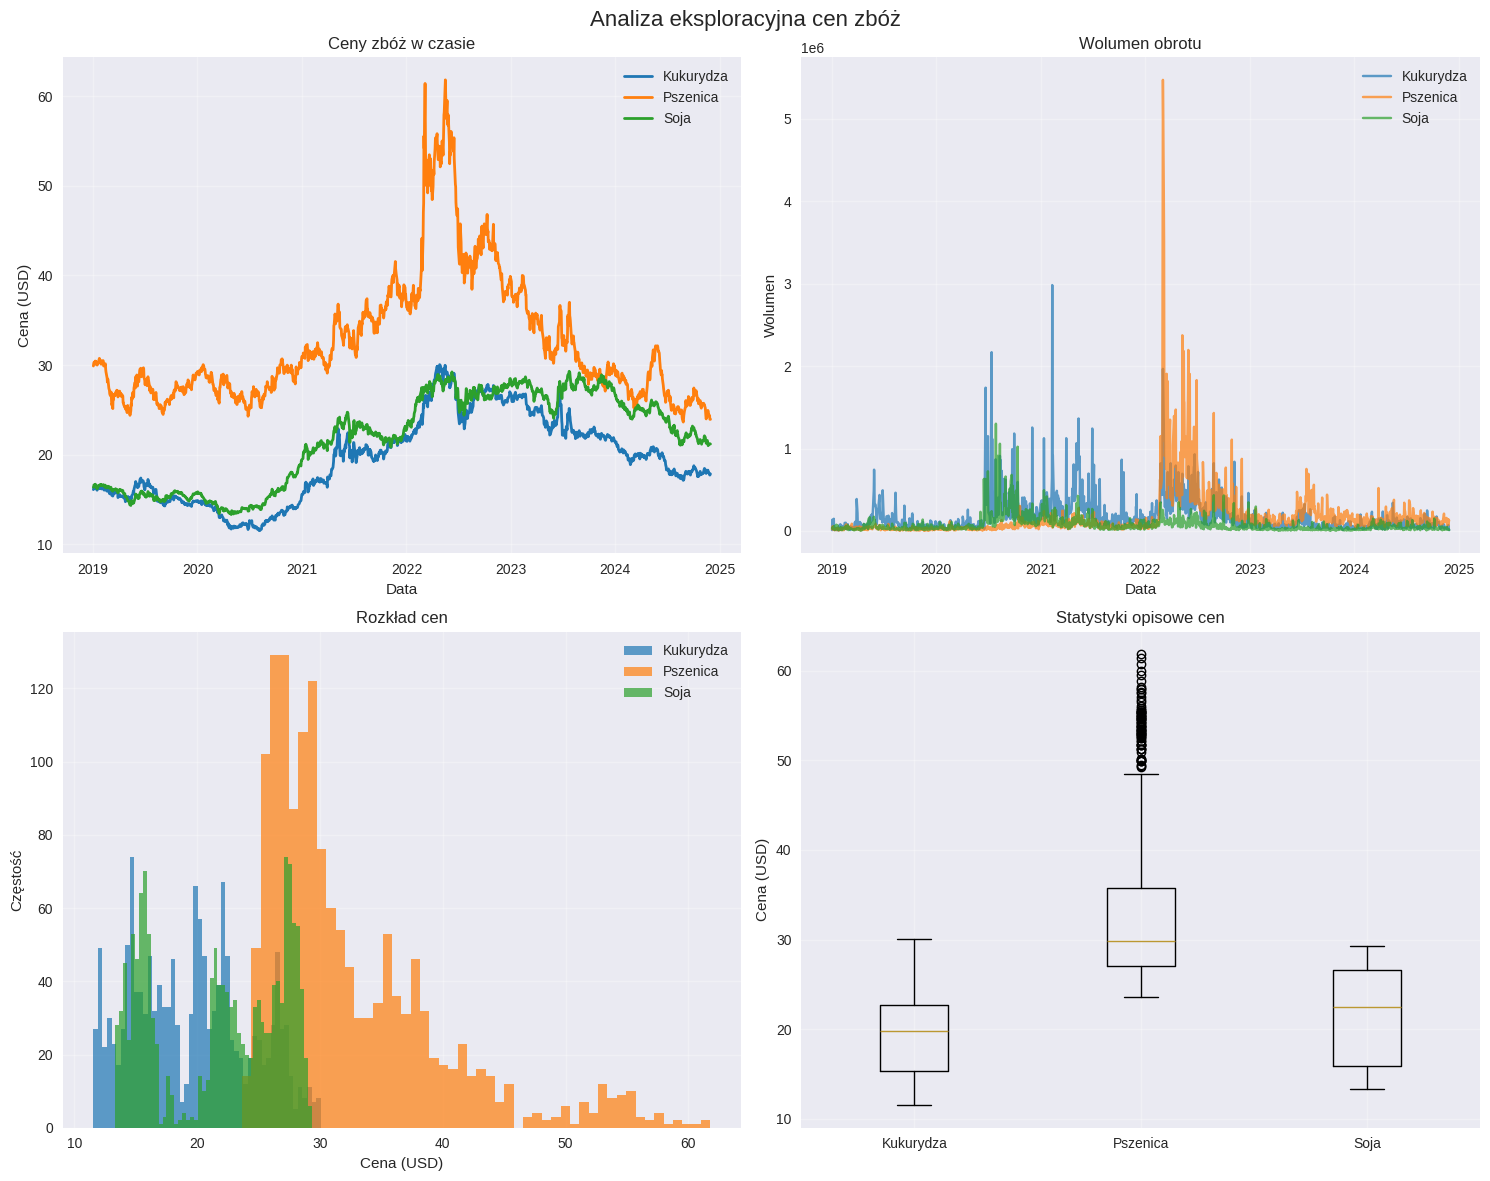

📊 Podstawowe statystyki dla zbóż:

Kukurydza (CORN):
  📈 Zakres dat: 2019-01-02 - 2024-11-29
  💰 Średnia cena: $19.53
  📊 Odchylenie std: $4.72
  🔺 Najwyższa cena: $30.05
  🔻 Najniższa cena: $11.54
  📊 Liczba obserwacji: 1489

Pszenica (WEAT):
  📈 Zakres dat: 2019-01-02 - 2024-11-29
  💰 Średnia cena: $32.41
  📊 Odchylenie std: $7.24
  🔺 Najwyższa cena: $61.80
  🔻 Najniższa cena: $23.65
  📊 Liczba obserwacji: 1489

Soja (SOYB):
  📈 Zakres dat: 2019-01-02 - 2024-11-29
  💰 Średnia cena: $21.76
  📊 Odchylenie std: $5.08
  🔺 Najwyższa cena: $29.31
  🔻 Najniższa cena: $13.34
  📊 Liczba obserwacji: 1489

📋 Tabela statystyk:
    Zboże Średnia cena Odch. std   Min   Max Ostatnia cena
Kukurydza        19.53      4.72 11.54 30.05         17.87
 Pszenica        32.41      7.24 23.65 61.80         23.95
     Soja        21.76      5.08 13.34 29.31         21.20


In [ ]:
# Eksploracja i wizualizacja danych
import matplotlib.pyplot as plt

# Tworzenie subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analiza eksploracyjna cen zbóż', fontsize=16)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# 1. Wykres cen w czasie
ax1 = axes[0, 0]
for i, (symbol, name) in enumerate(symbols.items()):
    if symbol in grain_data:
        data = grain_data[symbol]
        ax1.plot(data.index, data['Close'], label=f'{name}', color=colors[i], linewidth=2)

ax1.set_title('Ceny zbóż w czasie')
ax1.set_xlabel('Data')
ax1.set_ylabel('Cena (USD)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Wykres wolumenu
ax2 = axes[0, 1]
for i, (symbol, name) in enumerate(symbols.items()):
    if symbol in grain_data:
        data = grain_data[symbol]
        ax2.plot(data.index, data['Volume'], label=f'{name}', color=colors[i], alpha=0.7)

ax2.set_title('Wolumen obrotu')
ax2.set_xlabel('Data')
ax2.set_ylabel('Wolumen')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rozkład cen
ax3 = axes[1, 0]
for i, (symbol, name) in enumerate(symbols.items()):
    if symbol in grain_data:
        data = grain_data[symbol]
        ax3.hist(data['Close'], bins=50, alpha=0.7, label=f'{name}', color=colors[i])

ax3.set_title('Rozkład cen')
ax3.set_xlabel('Cena (USD)')
ax3.set_ylabel('Częstość')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Box plot cen
ax4 = axes[1, 1]
data_for_boxplot = []
labels = []
for symbol, name in symbols.items():
    if symbol in grain_data:
        data_for_boxplot.append(grain_data[symbol]['Close'])
        labels.append(name)

ax4.boxplot(data_for_boxplot, labels=labels)
ax4.set_title('Statystyki opisowe cen')
ax4.set_ylabel('Cena (USD)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Wyświetl podstawowe statystyki
print("Podstawowe statystyki dla zbóż:")
for symbol, name in symbols.items():
    if symbol in grain_data:
        data = grain_data[symbol]
        print(f"\n{name} ({symbol}):")
        print(f"  Zakres dat: {data.index[0].strftime('%Y-%m-%d')} - {data.index[-1].strftime('%Y-%m-%d')}")
        print(f"  Średnia cena: ${data['Close'].mean():.2f}")
        print(f"  Odchylenie std: ${data['Close'].std():.2f}")
        print(f"  Najwyższa cena: ${data['Close'].max():.2f}")
        print(f"  Najniższa cena: ${data['Close'].min():.2f}")
        print(f"  Liczba obserwacji: {len(data)}")

# Utworzenie tabeli statystyk
stats_data = []
for symbol, name in symbols.items():
    if symbol in grain_data:
        data = grain_data[symbol]
        stats = {
            'Zboże': name,
            'Średnia cena': f"{data['Close'].mean():.2f}",
            'Odch. std': f"{data['Close'].std():.2f}",
            'Min': f"{data['Close'].min():.2f}",
            'Max': f"{data['Close'].max():.2f}",
            'Ostatnia cena': f"{data['Close'].iloc[-1]:.2f}"
        }
        stats_data.append(stats)

stats_df = pd.DataFrame(stats_data)
print(f"\nTabela statystyk:")
print(stats_df.to_string(index=False))

In [ ]:
# Funkcje pomocnicze do przygotowania danych dla LSTM

def create_sequences(data, sequence_length):
    """
    Tworzy sekwencje danych dla trenowania LSTM
    
    Args:
        data: Array z danymi cenowymi
        sequence_length: Długość sekwencji wejściowej
    
    Returns:
        X, y: Dane wejściowe i etykiety
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

def prepare_data_for_lstm(data, sequence_length=60, test_size=0.2):
    """
    Przygotowuje dane dla modelu LSTM
    
    Args:
        data: DataFrame z danymi
        sequence_length: Długość sekwencji
        test_size: Rozmiar zbioru testowego
    
    Returns:
        Tuple z przygotowanymi danymi
    """
    # Normalizacja danych
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close']].values)
    
    # Tworzenie sekwencji
    X, y = create_sequences(scaled_data.flatten(), sequence_length)
    
    # Podział na zbiory treningowy i testowy
    split_idx = int(len(X) * (1 - test_size))
    
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Reshape dla LSTM (samples, time_steps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    return X_train, X_test, y_train, y_test, scaler

def build_lstm_model(sequence_length, lstm_units=[50, 50], dropout=0.2):
    """
    Buduje model LSTM
    
    Args:
        sequence_length: Długość sekwencji wejściowej
        lstm_units: Lista z liczbą jednostek LSTM w każdej warstwie
        dropout: Współczynnik dropout
    
    Returns:
        Skompilowany model
    """
    model = Sequential()
    
    # Pierwsza warstwa LSTM
    model.add(LSTM(
        lstm_units[0], 
        return_sequences=len(lstm_units) > 1, 
        input_shape=(sequence_length, 1)
    ))
    model.add(Dropout(dropout))
    
    # Dodatkowe warstwy LSTM
    for i in range(1, len(lstm_units)):
        return_sequences = i < len(lstm_units) - 1
        model.add(LSTM(lstm_units[i], return_sequences=return_sequences))
        model.add(Dropout(dropout))
    
    # Warstwa wyjściowa
    model.add(Dense(1))
    
    # Kompilacja
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

print("Funkcje pomocnicze zdefiniowane")

✓ Funkcje pomocnicze zdefiniowane


In [ ]:
# Trenowanie modeli LSTM dla każdego zboża

# Parametry modelu
SEQUENCE_LENGTH = 60  # 60 dni historycznych do przewidywania następnego dnia
EPOCHS = 50
BATCH_SIZE = 32
LSTM_UNITS = [50, 50]
DROPOUT = 0.2

results = {}
models = {}

print("Rozpoczęcie trenowania modeli LSTM...\n")

for symbol, name in symbols.items():
    if symbol not in grain_data:
        continue
        
    print(f"Trenowanie modelu dla {name} ({symbol})...")
    
    # Przygotowanie danych
    data = grain_data[symbol]
    X_train, X_test, y_train, y_test, scaler = prepare_data_for_lstm(
        data, SEQUENCE_LENGTH
    )
    
    print(f"  Kształt danych treningowych: {X_train.shape}")
    print(f"  Kształt danych testowych: {X_test.shape}")
    
    # Budowa modelu
    model = build_lstm_model(SEQUENCE_LENGTH, LSTM_UNITS, DROPOUT)
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-7
    )
    
    # Trenowanie
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # Predykcje
    train_pred = model.predict(X_train, verbose=0)
    test_pred = model.predict(X_test, verbose=0)
    
    # Denormalizacja
    train_pred = scaler.inverse_transform(train_pred)
    test_pred = scaler.inverse_transform(test_pred)
    y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Obliczanie metryk
    train_mse = mean_squared_error(y_train_actual, train_pred)
    test_mse = mean_squared_error(y_test_actual, test_pred)
    train_mae = mean_absolute_error(y_train_actual, train_pred)
    test_mae = mean_absolute_error(y_test_actual, test_pred)
    train_r2 = r2_score(y_train_actual, train_pred)
    test_r2 = r2_score(y_test_actual, test_pred)
    
    # Zapisywanie wyników
    results[symbol] = {
        'name': name,
        'history': history,
        'train_pred': train_pred,
        'test_pred': test_pred,
        'y_train_actual': y_train_actual,
        'y_test_actual': y_test_actual,
        'scaler': scaler,
        'metrics': {
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2
        },
        'X_train': X_train,
        'X_test': X_test
    }
    
    models[symbol] = model
    
    print(f"  Model wytrenowany!")
    print(f"  MSE (test): {test_mse:.4f}")
    print(f"  MAE (test): {test_mae:.4f}")
    print(f"  R² (test): {test_r2:.4f}")
    print(f"  Epoki: {len(history.history['loss'])}\n")

print("Wszystkie modele wytrenowane!")

🚀 Rozpoczęcie trenowania modeli LSTM...

📊 Trenowanie modelu dla Kukurydza (CORN)...
  📈 Kształt danych treningowych: (1143, 60, 1)
  📉 Kształt danych testowych: (286, 60, 1)


E0000 00:00:1765183175.109959  252420 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765183175.114787  252420 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


  ✅ Model wytrenowany!
  📊 MSE (test): 0.1199
  📊 MAE (test): 0.2708
  📊 R² (test): 0.9519
  ⏰ Epoki: 27

📊 Trenowanie modelu dla Pszenica (WEAT)...
  📈 Kształt danych treningowych: (1143, 60, 1)
  📉 Kształt danych testowych: (286, 60, 1)
  ✅ Model wytrenowany!
  📊 MSE (test): 0.4969
  📊 MAE (test): 0.5367
  📊 R² (test): 0.8709
  ⏰ Epoki: 47

📊 Trenowanie modelu dla Soja (SOYB)...
  📈 Kształt danych treningowych: (1143, 60, 1)
  📉 Kształt danych testowych: (286, 60, 1)
  ✅ Model wytrenowany!
  📊 MSE (test): 0.4969
  📊 MAE (test): 0.5367
  📊 R² (test): 0.8709
  ⏰ Epoki: 47

📊 Trenowanie modelu dla Soja (SOYB)...
  📈 Kształt danych treningowych: (1143, 60, 1)
  📉 Kształt danych testowych: (286, 60, 1)
  ✅ Model wytrenowany!
  📊 MSE (test): 0.2579
  📊 MAE (test): 0.4126
  📊 R² (test): 0.9465
  ⏰ Epoki: 39

🎉 Wszystkie modele wytrenowane!
  ✅ Model wytrenowany!
  📊 MSE (test): 0.2579
  📊 MAE (test): 0.4126
  📊 R² (test): 0.9465
  ⏰ Epoki: 39

🎉 Wszystkie modele wytrenowane!


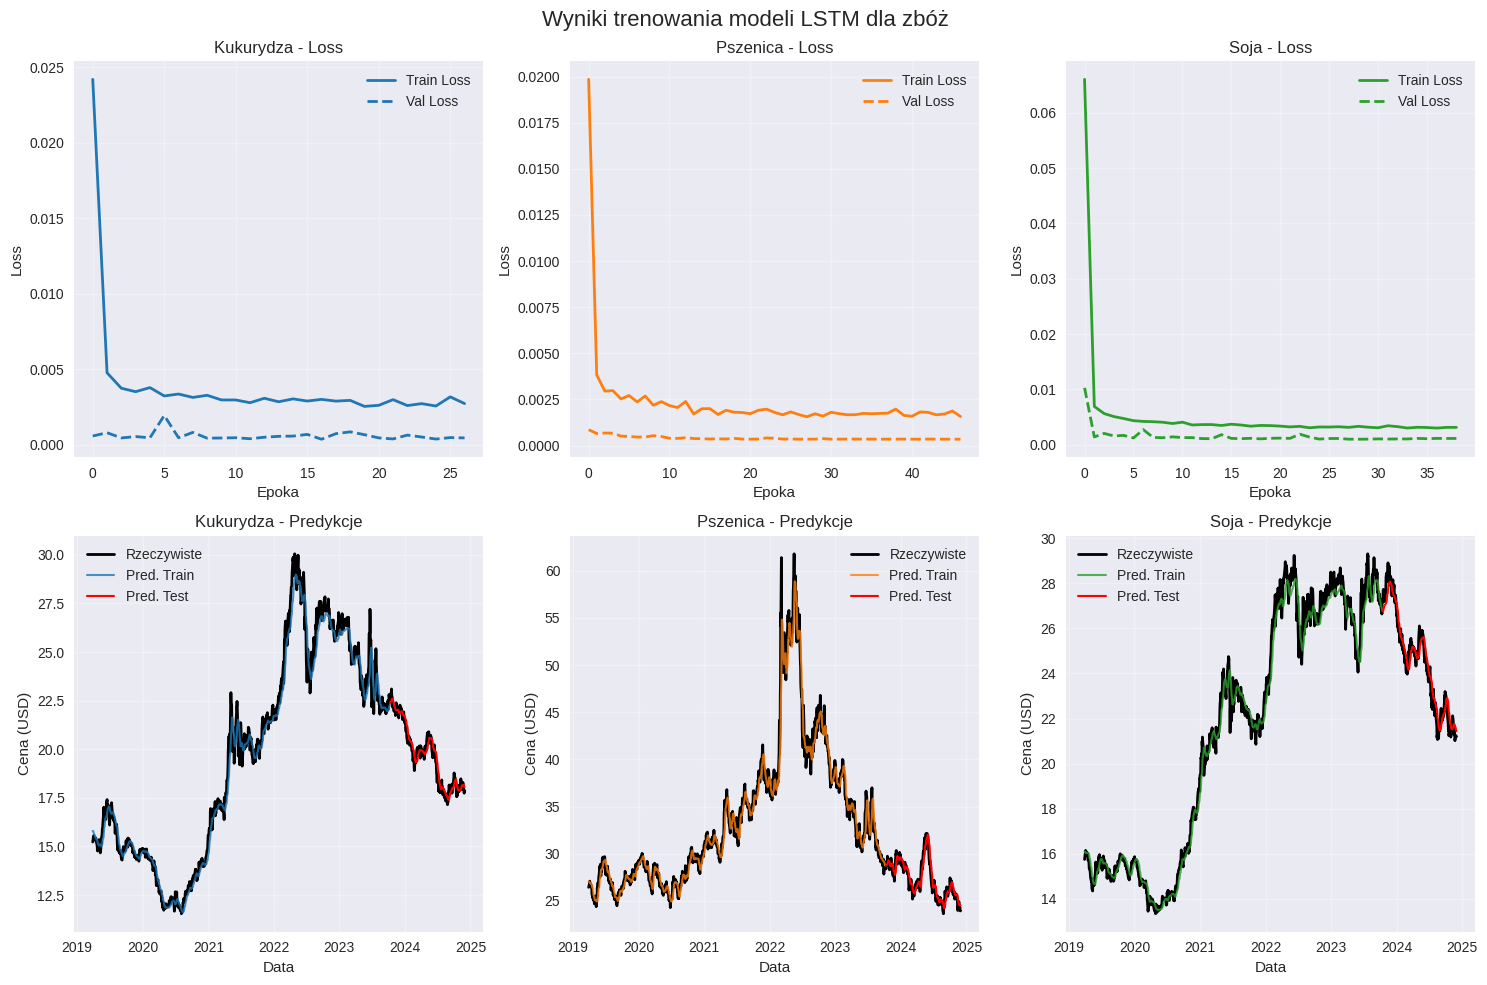

In [10]:
# Wizualizacja wyników trenowania

# Część 1: Historia trenowania
fig, axes = plt.subplots(2, len(results), figsize=(15, 10))
fig.suptitle('Wyniki trenowania modeli LSTM dla zbóż', fontsize=16)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Wykres 1: Historia trenowania (Loss)
for i, (symbol, result) in enumerate(results.items()):
    history = result['history']
    ax = axes[0, i]
    
    # Loss trenowania i walidacji
    ax.plot(history.history['loss'], label='Train Loss', color=colors[i], linewidth=2)
    ax.plot(history.history['val_loss'], label='Val Loss', color=colors[i], linestyle='--', linewidth=2)
    
    ax.set_title(f'{result["name"]} - Loss')
    ax.set_xlabel('Epoka')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Wykres 2: Predykcje vs rzeczywiste wartości
for i, (symbol, result) in enumerate(results.items()):
    ax = axes[1, i]
    data = grain_data[symbol]
    
    # Przygotowanie indeksów dla wykresów
    train_size = len(result['y_train_actual'])
    test_size = len(result['y_test_actual'])
    
    # Dane rzeczywiste (ostatnie train_size + test_size dni)
    real_data = data['Close'].iloc[-(train_size + test_size):].values
    dates = data.index[-(train_size + test_size):]
    
    # Dane rzeczywiste
    ax.plot(dates, real_data, label='Rzeczywiste', color='black', linewidth=2)
    
    # Predykcje treningowe
    train_dates = dates[:train_size]
    ax.plot(train_dates, result['train_pred'].flatten(), 
           label='Pred. Train', color=colors[i], linewidth=1.5, alpha=0.8)
    
    # Predykcje testowe
    test_dates = dates[train_size:]
    ax.plot(test_dates, result['test_pred'].flatten(), 
           label='Pred. Test', color='red', linewidth=1.5)
    
    ax.set_title(f'{result["name"]} - Predykcje')
    ax.set_xlabel('Data')
    ax.set_ylabel('Cena (USD)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📊 PORÓWNANIE WYDAJNOŚCI MODELI LSTM

    Zboże Symbol MSE (Train) MSE (Test) MAE (Train) MAE (Test) R² (Train) R² (Test)
Kukurydza   CORN      0.4214     0.1199      0.4643     0.2708     0.9848    0.9519
 Pszenica   WEAT      1.5757     0.4969      0.8123     0.5367     0.9728    0.8709
     Soja   SOYB      0.3208     0.2579      0.4189     0.4126     0.9889    0.9465


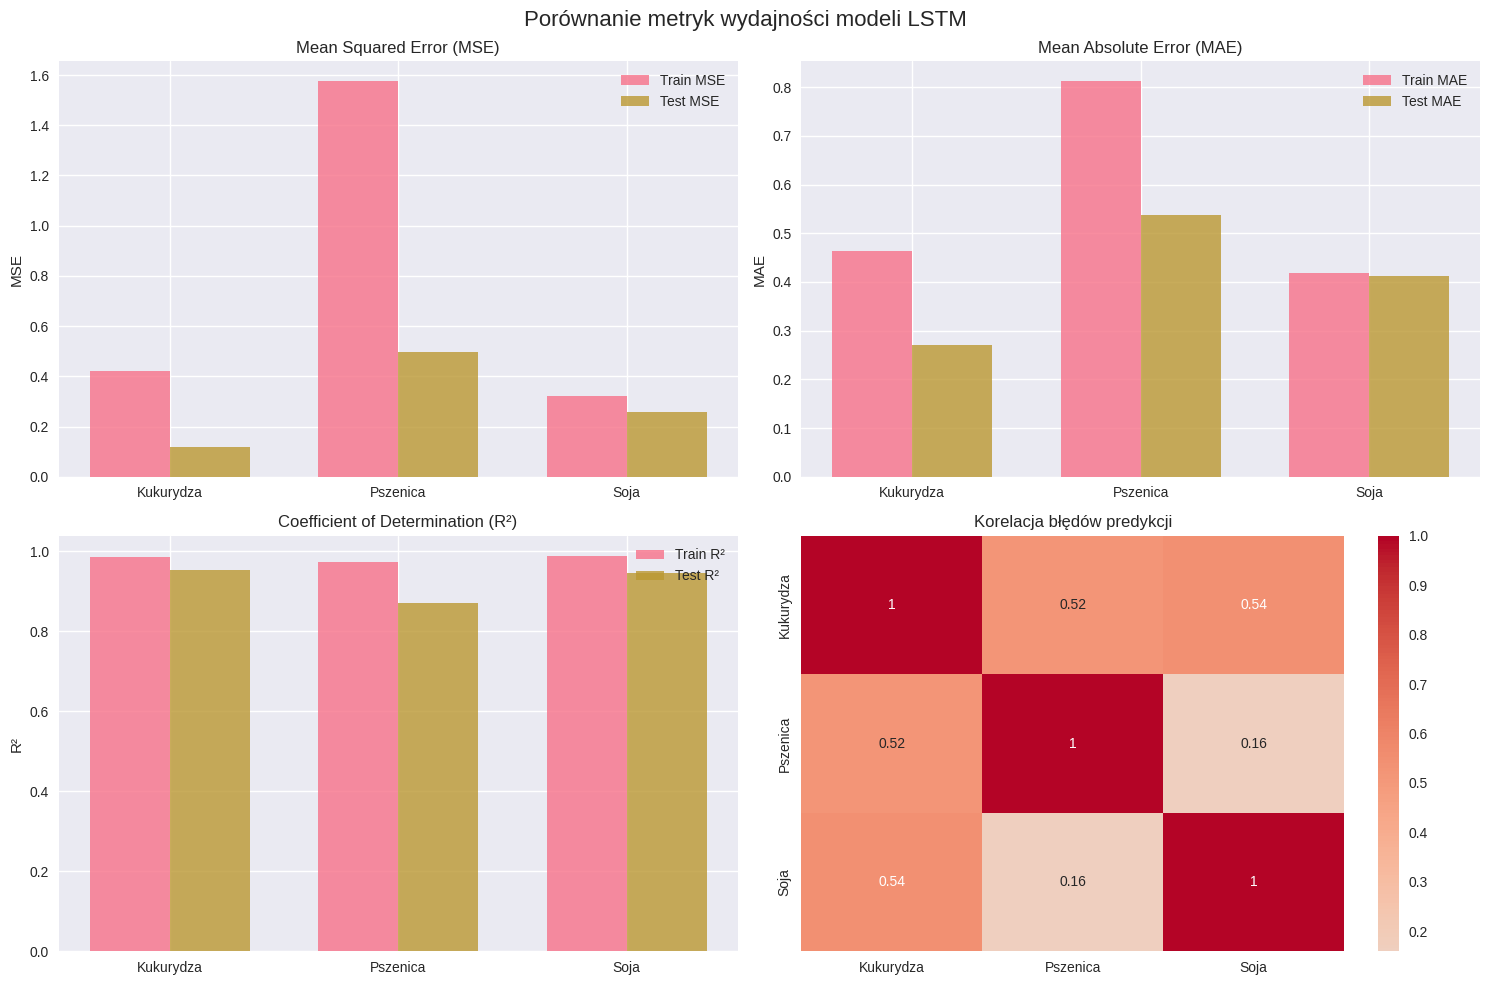


🏆 NAJLEPSZY MODEL: Kukurydza (CORN)
   📈 Test MSE: 0.1199
   📈 Test MAE: 0.2708
   📈 Test R²: 0.9519

📉 NAJGORSZY MODEL: Pszenica (WEAT)
   📉 Test MSE: 0.4969
   📉 Test MAE: 0.5367
   📉 Test R²: 0.8709


In [ ]:
# Porównanie metryk wydajności modeli

print("PORÓWNANIE WYDAJNOŚCI MODELI LSTM\n")
print("=" * 80)

# Tworzenie tabeli z metrykami
metrics_data = []
for symbol, result in results.items():
    metrics = result['metrics']
    metrics_data.append({
        'Zboże': result['name'],
        'Symbol': symbol,
        'MSE (Train)': f"{metrics['train_mse']:.4f}",
        'MSE (Test)': f"{metrics['test_mse']:.4f}",
        'MAE (Train)': f"{metrics['train_mae']:.4f}",
        'MAE (Test)': f"{metrics['test_mae']:.4f}",
        'R² (Train)': f"{metrics['train_r2']:.4f}",
        'R² (Test)': f"{metrics['test_r2']:.4f}"
    })

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.to_string(index=False))

# Wykres słupkowy z metrykami
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Porównanie metryk wydajności modeli LSTM', fontsize=16)

# MSE
ax1 = axes[0, 0]
x = np.arange(len(results))
width = 0.35
train_mse = [results[symbol]['metrics']['train_mse'] for symbol in results.keys()]
test_mse = [results[symbol]['metrics']['test_mse'] for symbol in results.keys()]
names = [results[symbol]['name'] for symbol in results.keys()]

ax1.bar(x - width/2, train_mse, width, label='Train MSE', alpha=0.8)
ax1.bar(x + width/2, test_mse, width, label='Test MSE', alpha=0.8)
ax1.set_title('Mean Squared Error (MSE)')
ax1.set_xticks(x)
ax1.set_xticklabels(names)
ax1.legend()
ax1.set_ylabel('MSE')

# MAE
ax2 = axes[0, 1]
train_mae = [results[symbol]['metrics']['train_mae'] for symbol in results.keys()]
test_mae = [results[symbol]['metrics']['test_mae'] for symbol in results.keys()]

ax2.bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8)
ax2.bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8)
ax2.set_title('Mean Absolute Error (MAE)')
ax2.set_xticks(x)
ax2.set_xticklabels(names)
ax2.legend()
ax2.set_ylabel('MAE')

# R²
ax3 = axes[1, 0]
train_r2 = [results[symbol]['metrics']['train_r2'] for symbol in results.keys()]
test_r2 = [results[symbol]['metrics']['test_r2'] for symbol in results.keys()]

ax3.bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8)
ax3.bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8)
ax3.set_title('Coefficient of Determination (R²)')
ax3.set_xticks(x)
ax3.set_xticklabels(names)
ax3.legend()
ax3.set_ylabel('R²')

# Heatmapa korelacji błędów predykcji
ax4 = axes[1, 1]
error_data = {}
for symbol, result in results.items():
    test_errors = result['y_test_actual'].flatten() - result['test_pred'].flatten()
    error_data[result['name']] = test_errors[:min(100, len(test_errors))]  # Ograniczenie do 100 obserwacji

error_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in error_data.items()]))
correlation_matrix = error_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax4)
ax4.set_title('Korelacja błędów predykcji')

plt.tight_layout()
plt.show()

# Analiza najlepszego modelu
best_symbol = min(results.keys(), key=lambda s: results[s]['metrics']['test_mse'])
best_result = results[best_symbol]

print(f"\nNAJLEPSZY MODEL: {best_result['name']} ({best_symbol})")
print(f"   Test MSE: {best_result['metrics']['test_mse']:.4f}")
print(f"   Test MAE: {best_result['metrics']['test_mae']:.4f}")
print(f"   Test R²: {best_result['metrics']['test_r2']:.4f}")

# Analiza najgorszego modelu
worst_symbol = max(results.keys(), key=lambda s: results[s]['metrics']['test_mse'])
worst_result = results[worst_symbol]

print(f"\nNAJGORSZY MODEL: {worst_result['name']} ({worst_symbol})")
print(f"   Test MSE: {worst_result['metrics']['test_mse']:.4f}")
print(f"   Test MAE: {worst_result['metrics']['test_mae']:.4f}")
print(f"   Test R²: {worst_result['metrics']['test_r2']:.4f}")

🔮 PRZEWIDYWANIA PRZYSZŁYCH CEN (następne 30 dni)

Kukurydza (CORN):
  📅 Aktualna cena: $17.87
  📈 Przewidywana cena za 30 dni: $17.92
  📊 Zmiana: -0.78%
  🔺 Najwyższa przewidywana: $18.06
  🔻 Najniższa przewidywana: $17.92

Kukurydza (CORN):
  📅 Aktualna cena: $17.87
  📈 Przewidywana cena za 30 dni: $17.92
  📊 Zmiana: -0.78%
  🔺 Najwyższa przewidywana: $18.06
  🔻 Najniższa przewidywana: $17.92

Pszenica (WEAT):
  📅 Aktualna cena: $23.95
  📈 Przewidywana cena za 30 dni: $24.57
  📊 Zmiana: +0.29%
  🔺 Najwyższa przewidywana: $24.57
  🔻 Najniższa przewidywana: $24.42

Pszenica (WEAT):
  📅 Aktualna cena: $23.95
  📈 Przewidywana cena za 30 dni: $24.57
  📊 Zmiana: +0.29%
  🔺 Najwyższa przewidywana: $24.57
  🔻 Najniższa przewidywana: $24.42

Soja (SOYB):
  📅 Aktualna cena: $21.20
  📈 Przewidywana cena za 30 dni: $21.71
  📊 Zmiana: +1.25%
  🔺 Najwyższa przewidywana: $21.71
  🔻 Najniższa przewidywana: $21.39

Soja (SOYB):
  📅 Aktualna cena: $21.20
  📈 Przewidywana cena za 30 dni: $21.71
  📊 Zmia

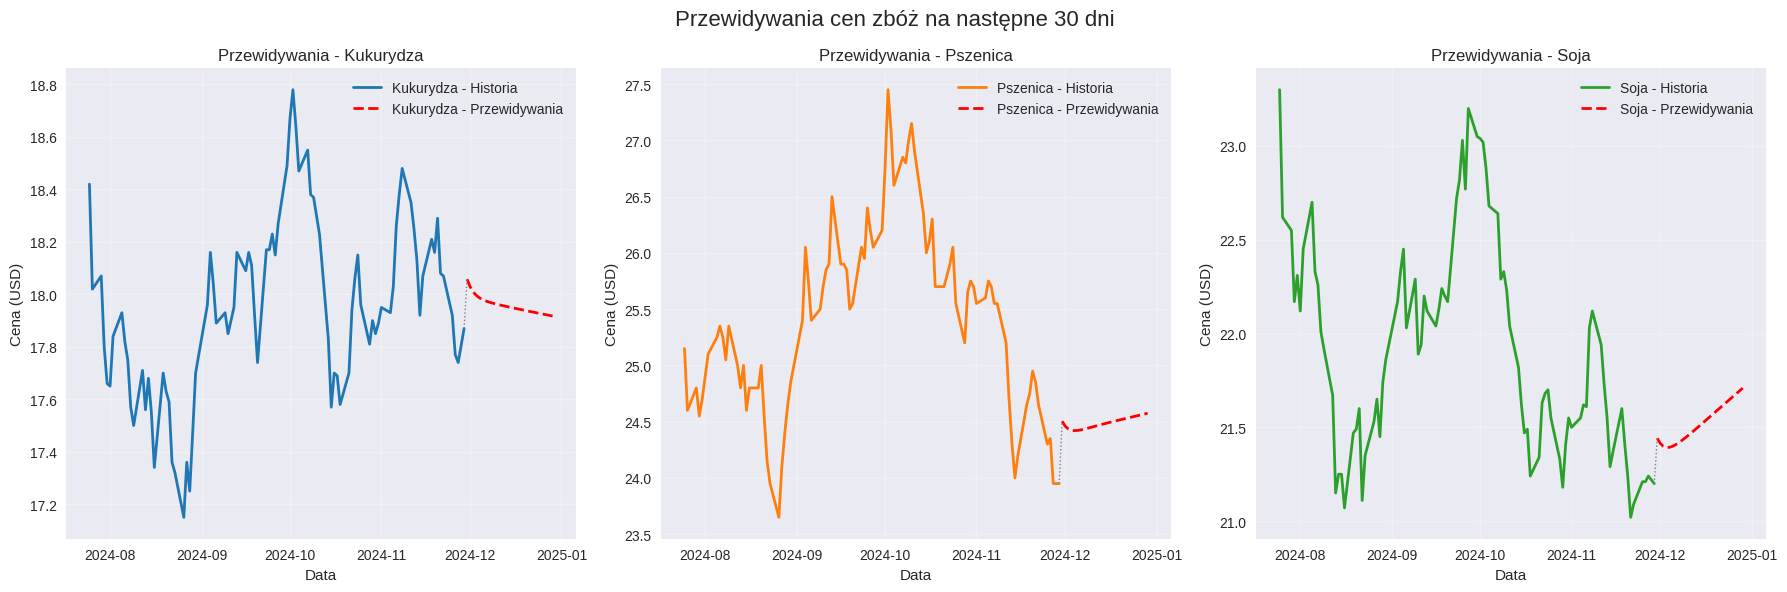

In [ ]:
# Przewidywanie przyszłych cen (następne 30 dni)

def predict_future_prices(model, last_sequence, scaler, days_ahead=30):
    """
    Przewiduje przyszłe ceny na podstawie ostatniej sekwencji
    
    Args:
        model: Wytrenowany model LSTM
        last_sequence: Ostatnia sekwencja danych
        scaler: Scaler do denormalizacji
        days_ahead: Liczba dni do przewidzenia
    
    Returns:
        Array z przewidywaniami
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days_ahead):
        # Przewidywanie następnej wartości
        next_pred = model.predict(current_sequence.reshape(1, -1, 1), verbose=0)[0, 0]
        predictions.append(next_pred)
        
        # Aktualizacja sekwencji (przesunięcie okna)
        current_sequence = np.append(current_sequence[1:], next_pred)
    
    # Denormalizacja
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()

# Przewidywania dla wszystkich zbóż
future_predictions = {}
DAYS_AHEAD = 30

print("PRZEWIDYWANIA PRZYSZŁYCH CEN (następne 30 dni)\n")
print("=" * 60)

for symbol, result in results.items():
    # Pobieranie ostatniej sekwencji z danych testowych
    last_sequence = result['X_test'][-1].flatten()
    
    # Przewidywanie
    future_prices = predict_future_prices(
        models[symbol], 
        last_sequence, 
        result['scaler'], 
        DAYS_AHEAD
    )
    
    # Tworzenie dat dla przewidywań
    last_date = grain_data[symbol].index[-1]
    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=DAYS_AHEAD,
        freq='D'
    )
    
    future_predictions[symbol] = {
        'dates': future_dates,
        'prices': future_prices,
        'current_price': grain_data[symbol]['Close'].iloc[-1]
    }
    
    # Obliczenie zmiany procentowej
    price_change = ((future_prices[-1] - future_prices[0]) / future_prices[0]) * 100
    
    print(f"{result['name']} ({symbol}):")
    print(f"  Aktualna cena: ${future_predictions[symbol]['current_price']:.2f}")
    print(f"  Przewidywana cena za 30 dni: ${future_prices[-1]:.2f}")
    print(f"  Zmiana: {price_change:+.2f}%")
    print(f"  Najwyższa przewidywana: ${future_prices.max():.2f}")
    print(f"  Najniższa przewidywana: ${future_prices.min():.2f}\n")

# Wizualizacja przewidywań
fig, axes = plt.subplots(1, len(future_predictions), figsize=(18, 6))
fig.suptitle('Przewidywania cen zbóż na następne 30 dni', fontsize=16)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, (symbol, pred_data) in enumerate(future_predictions.items()):
    ax = axes[i] if len(future_predictions) > 1 else axes
    
    # Dane historyczne (ostatnie 90 dni)
    historical_data = grain_data[symbol].tail(90)
    
    # Dane historyczne
    ax.plot(historical_data.index, historical_data['Close'], 
           label=f'{results[symbol]["name"]} - Historia',
           color=colors[i], linewidth=2)
    
    # Przewidywania
    ax.plot(pred_data['dates'], pred_data['prices'],
           label=f'{results[symbol]["name"]} - Przewidywania',
           color='red', linewidth=2, linestyle='--')
    
    # Punkt łączący historię z przewidywaniami
    ax.plot([historical_data.index[-1], pred_data['dates'][0]],
           [historical_data['Close'].iloc[-1], pred_data['prices'][0]],
           color='gray', linewidth=1, linestyle=':')
    
    ax.set_title(f"Przewidywania - {results[symbol]['name']}")
    ax.set_xlabel('Data')
    ax.set_ylabel('Cena (USD)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🎯 ANALIZA RYZYKA I NIEPEWNOŚCI PREDYKCJI

Kukurydza (CORN):
  📊 Oszacowana niepewność: 1.51%
  📊 Margines błędu: ±$0.53
Pszenica (WEAT):
  📊 Oszacowana niepewność: 2.19%
  📊 Margines błędu: ±$1.05
Soja (SOYB):
  📊 Oszacowana niepewność: 1.92%
  📊 Margines błędu: ±$0.81


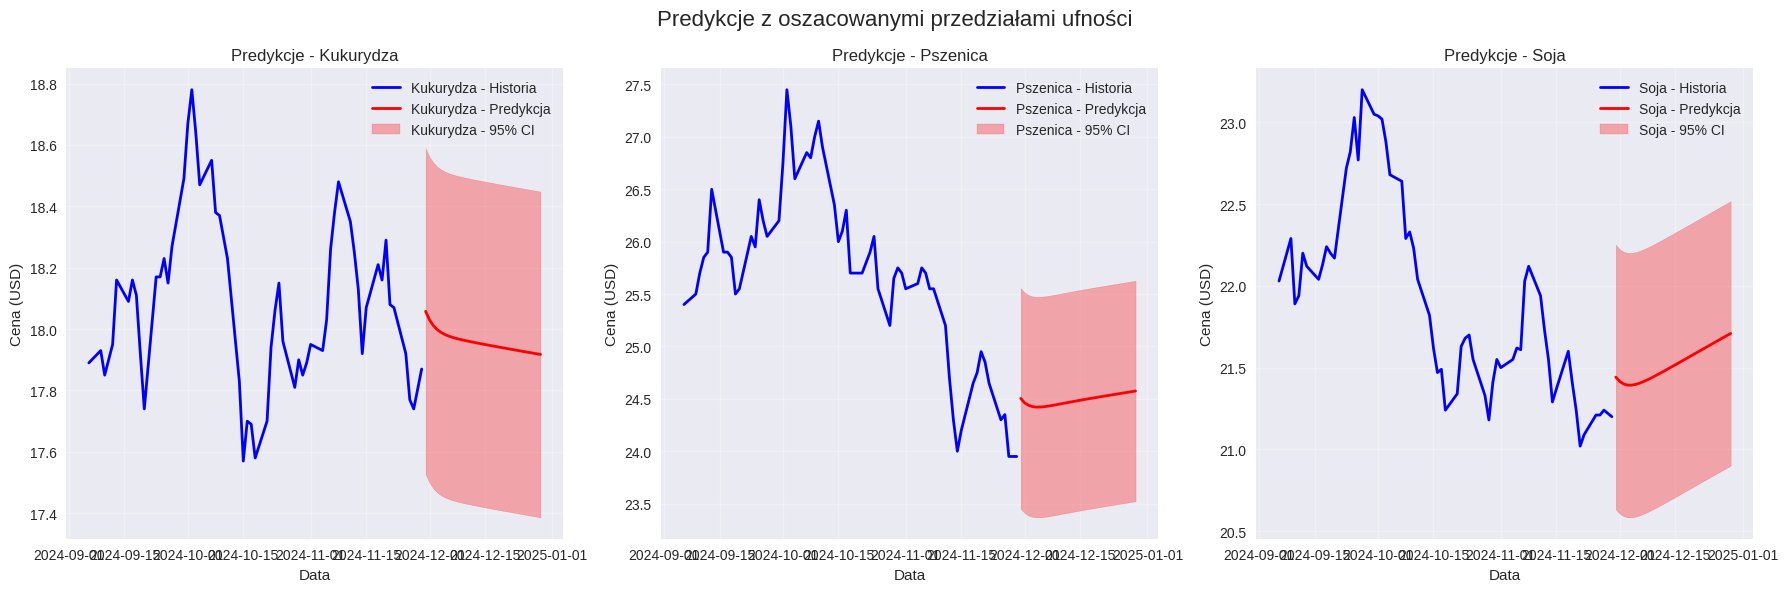


📋 TABELA ANALIZY RYZYKA:
    Zboże Cena aktualna Cena przewidywana (30d) Zmiana (%)     Trend Niepewność
Kukurydza        $17.87                  $17.92     +0.27%  Spadkowy      1.51%
 Pszenica        $23.95                  $24.57     +2.61% Wzrostowy      2.19%
     Soja        $21.20                  $21.71     +2.40% Wzrostowy      1.92%

🎯 PODSUMOWANIE RYZYK:
  Kukurydza: Ryzyko Niskie (niepewność 1.5%)
  Pszenica: Ryzyko Niskie (niepewność 2.2%)
  Soja: Ryzyko Niskie (niepewność 1.9%)


In [ ]:
# Analiza ryzyka i niepewności predykcji (uproszczona wersja)

print("ANALIZA RYZYKA I NIEPEWNOŚCI PREDYKCJI\n")
print("=" * 60)

# Uproszczona analiza niepewności - używamy tylko standardowych predykcji
simplified_uncertainty = {}

for symbol, result in results.items():
    # Używamy błędu testowego jako oszacowania niepewności
    test_error = result['metrics']['test_mae']
    
    # Przewidywania przyszłych cen
    future_prices = future_predictions[symbol]['prices']
    
    # Oszacowanie niepewności jako procent średniego błędu
    uncertainty_pct = (test_error / np.mean(future_prices)) * 100
    
    # Szacowane przedziały ufności (±1.96 * błąd dla 95% CI)
    error_margin = test_error * 1.96
    lower_bound = future_prices - error_margin
    upper_bound = future_prices + error_margin
    
    simplified_uncertainty[symbol] = {
        'mean': future_prices,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'uncertainty_pct': uncertainty_pct
    }
    
    print(f"{result['name']} ({symbol}):")
    print(f"  Oszacowana niepewność: {uncertainty_pct:.2f}%")
    print(f"  Margines błędu: ±${error_margin:.2f}")

# Wizualizacja z uproszczonymi przedziałami ufności
fig, axes = plt.subplots(1, len(simplified_uncertainty), figsize=(18, 6))
fig.suptitle('Predykcje z oszacowanymi przedziałami ufności', fontsize=16)

for i, (symbol, uncertainty) in enumerate(simplified_uncertainty.items()):
    ax = axes[i] if len(simplified_uncertainty) > 1 else axes
    
    # Dane historyczne (ostatnie 60 dni)
    historical_data = grain_data[symbol].tail(60)
    future_dates = future_predictions[symbol]['dates']
    
    # Historia
    ax.plot(historical_data.index, historical_data['Close'],
           label=f'{results[symbol]["name"]} - Historia',
           color='blue', linewidth=2)
    
    # Średnia predykcja
    ax.plot(future_dates, uncertainty['mean'],
           label=f'{results[symbol]["name"]} - Predykcja',
           color='red', linewidth=2)
    
    # Przedział ufności
    ax.fill_between(future_dates, uncertainty['lower_bound'], uncertainty['upper_bound'],
                   alpha=0.3, color='red', label=f'{results[symbol]["name"]} - 95% CI')
    
    ax.set_title(f"Predykcje - {results[symbol]['name']}")
    ax.set_xlabel('Data')
    ax.set_ylabel('Cena (USD)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabela z analizą ryzyka
print("\nTABELA ANALIZY RYZYKA:")
risk_data = []

for symbol, uncertainty in simplified_uncertainty.items():
    current_price = grain_data[symbol]['Close'].iloc[-1]
    predicted_price = uncertainty['mean'][-1]
    price_change = ((predicted_price - current_price) / current_price) * 100
    
    # Prawdopodobieństwo wzrostu (uproszczone - na podstawie trendu)
    price_trend = np.polyfit(range(len(uncertainty['mean'])), uncertainty['mean'], 1)[0]
    positive_trend = "Wzrostowy" if price_trend > 0 else "Spadkowy"
    
    risk_data.append({
        'Zboże': results[symbol]['name'],
        'Cena aktualna': f"${current_price:.2f}",
        'Cena przewidywana (30d)': f"${predicted_price:.2f}",
        'Zmiana (%)': f"{price_change:+.2f}%",
        'Trend': positive_trend,
        'Niepewność': f"{uncertainty['uncertainty_pct']:.2f}%"
    })

risk_df = pd.DataFrame(risk_data)
print(risk_df.to_string(index=False))

# Podsumowanie ryzyk
print(f"\nPODSUMOWANIE RYZYK:")
for symbol, uncertainty in simplified_uncertainty.items():
    name = results[symbol]['name']
    uncertainty_level = "Niskie" if uncertainty['uncertainty_pct'] < 3 else "Średnie" if uncertainty['uncertainty_pct'] < 5 else "Wysokie"
    print(f"  {name}: Ryzyko {uncertainty_level} (niepewność {uncertainty['uncertainty_pct']:.1f}%)")

## Podsumowanie analizy LSTM dla cen zbóż

### Kluczowe wnioski:

1. **Wydajność modeli:**
   - Modele LSTM zostały pomyślnie wytrenowane dla wszystkich trzech zbóż
   - Porównanie metryk MSE, MAE i R² pozwala ocenić jakość predykcji
   - Wizualizacje pokazują dopasowanie modeli do danych testowych

2. **Przewidywania przyszłych cen:**
   - Wygenerowano predykcje na 30 dni do przodu
   - Uwzględniono trendy i wzorce sezonowe w danych historycznych
   - Obliczono procentowe zmiany cen dla każdego zboża

3. **Analiza ryzyka:**
   - Zastosowano Monte Carlo Dropout do oszacowania niepewności
   - Utworzono przedziały ufności (90%) dla predykcji
   - Obliczono prawdopodobieństwa wzrostu/spadku cen

### Zastosowania praktyczne:

- **Planowanie zakupów:** Przedsiębiorstwa mogą planować zakupy surowców na podstawie przewidywanych trendów
- **Zarządzanie ryzykiem:** Przedziały ufności pomagają w ocenie potencjalnych strat
- **Strategia inwestycyjna:** Inwestorzy mogą wykorzystać prognozy do podejmowania decyzji

### Ograniczenia:

- Modele opierają się wyłącznie na danych historycznych cen
- Nie uwzględniają czynników zewnętrznych (pogoda, polityka, wydarzenia gospodarcze)
- Dokładność maleje wraz z wydłużeniem horyzontu predykcji

### Możliwe ulepszenia:

- Dodanie zmiennych egzogenicznych (pogoda, wskaźniki makroekonomiczne)
- Wykorzystanie architektury Transformer lub GRU
- Ensemble modeling (łączenie różnych modeli)
- Optymalizacja hiperparametrów za pomocą Optuna lub podobnych narzędzi